In [2]:
import os
import sys
import glob
import pickle
import yaml
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [3]:
sys.path.append("..")

In [4]:
from metrics import far_at_frr, eer
from utils import *

In [5]:
SAVE = False

In [6]:
frr_point = 1


results_dir = "../results/2022-01-28"

run_ids = os.listdir(results_dir)

results_dict = {}

#plt.figure(figsize=(15, 10))
for run_id in tqdm(run_ids):
    
    config_file = glob.glob(f"{results_dir}/{run_id}/*.yaml")[0]
    config = yaml.load(open(config_file), Loader=yaml.FullLoader)
    
    
    embeddings_name = config["embeddings_name"] # ['clova', 'speechbrain', 'xvector']
    embeddings_type = config["embeddings_type"]

    score_type = config["score_type"] # ['cos_emb_avg', 'cos_sc_avg', 'plda_sph', 'plda_diag']
    by_the_book = config["by_the_book"] # plda scoring
    preprocessing_name = config["preprocessing_name"]
    recognizer = config["recognizer"] # ['exp_avg', 'memory'], use 'memory' for 'cos_sc_avg'
    sequential_updates = config["sequential_updates"]
    
#     if embeddings_name in ["speechbrain", "clova"]:
#         continue
        
    run_name = f"{embeddings_name}_{embeddings_type}_{score_type}"
    if not sequential_updates:
        run_name = f"{run_name}_offline"
    if embeddings_name == "xvector" and by_the_book:
        run_name = f"{run_name}_by-the-book"
    print(run_name)
    
    
    FAR_known_list = []
    FAR_unknown_list = []
    EER_known_list = []
    EER_unknown_list = []
    
    thresholds = []
    alphas = []
    
    for i in range(len(os.listdir(f"{results_dir}/{run_id}"))-1):
        
        results_dir_iter = f"{results_dir}/{run_id}/{i}"
        
        try:
            with open(f"{results_dir_iter}/params.pickle", "rb") as params_file:
                params = pickle.load(params_file)
            #print(params)
        except:
            print(f"Failed to load params for {results_dir_iter}")
            continue
            
        thresholds += [params["threshold"]]
        alpha = params.get("alpha", None)
        if alpha is None:
            alpha = -1
        alphas += [alpha]
        
       
        try:
            scores_target_pooled = np.loadtxt(f"{results_dir_iter}/scores_tar.txt")
            scores_impostor_known_pooled = np.loadtxt(f"{results_dir_iter}/scores_imp.txt")
            scores_impostor_unknown_pooled = np.loadtxt(f"{results_dir_iter}/scores_imp_unk.txt")

            scores_target_pooled_enrich = np.loadtxt(f"{results_dir_iter}/scores_adapted_tar.txt")
            scores_impostor_known_pooled_enrich = np.loadtxt(f"{results_dir_iter}/scores_adapted_imp.txt")
            scores_impostor_unknown_pooled_enrich = np.loadtxt(f"{results_dir_iter}/scores_adapted_imp_unk.txt")
        except:
            continue
        
        # no adaptation
#         scores, labels = concatenate_with_labels(scores_impostor_known_pooled, scores_target_pooled)
#         FAR_at_FRR_known, _ = far_at_frr(scores, labels, frr_point=frr_point)
#         EER_known = eer(scores, labels)[0]*100

#         scores, labels = concatenate_with_labels(scores_impostor_unknown_pooled, scores_target_pooled)
#         FAR_at_FRR_unknown, _ = far_at_frr(scores, labels, frr_point=frr_point)
#         EER_unknown = eer(scores, labels)[0]*100
    
        # adapted
        scores, labels = concatenate_with_labels(scores_impostor_known_pooled_enrich, scores_target_pooled_enrich)
        FAR_at_FRR_known, _ = far_at_frr(scores, labels, frr_point=frr_point)
        EER_known = eer(scores, labels)[0]*100

        scores, labels = concatenate_with_labels(scores_impostor_unknown_pooled_enrich, scores_target_pooled_enrich)
        FAR_at_FRR_unknown, _ = far_at_frr(scores, labels, frr_point=frr_point)
        EER_unknown = eer(scores, labels)[0]*100

        FAR_known_list += [FAR_at_FRR_known]
        FAR_unknown_list += [FAR_at_FRR_unknown]
        EER_known_list += [EER_known]
        EER_unknown_list += [EER_unknown]

    
    thresholds = np.array(thresholds)
    alphas = np.array(alphas)
    
    FAR_known_list = np.array(FAR_known_list)
    FAR_unknown_list = np.array(FAR_unknown_list)
    EER_known_list = np.array(EER_known_list)
    EER_unknown_list = np.array(EER_unknown_list)
    
    
    results_dict_run = {}
    results_dict_run['thresholds'] = thresholds
    results_dict_run['alphas'] = alphas
    results_dict_run['FAR_known'] = FAR_known_list
    results_dict_run['FAR_unknown'] = FAR_unknown_list
    results_dict_run['EER_know'] = EER_known_list
    results_dict_run['EER_unknown'] = EER_unknown_list
    
    results_dict[run_name] = results_dict_run
    
#     #TODO: unique combinations (itertools) of parameters for this run_id
#     alpha_unique, idx = np.unique(alphas, return_inverse=True)
#     for i, alpha in enumerate(alpha_unique):
#         mask = idx == i
    
#         if alpha >= 0:
#             label = f"{run_name}_{alpha}"  
#         else:
#             label = run_name
#         # visualize
#         #plt.figure(figsize=(8,5))
#         plt.plot(thresholds[mask], EER_known_list[mask], label=label);
#         plt.legend()    
    
# #plt.savefig("clova_EER_known.png")
    

  0%|          | 0/10 [00:00<?, ?it/s]

speechbrain_trimmed_2sec_cos_emb_avg


 10%|█         | 1/10 [00:35<05:21, 35.73s/it]

speechbrain_trimmed_2sec_cos_emb_avg_offline


 20%|██        | 2/10 [00:44<02:40, 20.11s/it]

speechbrain_trimmed_2sec_plda_sph


 30%|███       | 3/10 [01:21<03:13, 27.59s/it]

clova_2sec_cos_emb_avg_offline


 40%|████      | 4/10 [01:30<02:01, 20.23s/it]

speechbrain_trimmed_2sec_cos_sc_avg


 50%|█████     | 5/10 [01:39<01:20, 16.17s/it]

clova_2sec_cos_sc_avg


 60%|██████    | 6/10 [01:48<00:54, 13.74s/it]

xvector_trimmed_2sec_plda_diag


 70%|███████   | 7/10 [02:23<01:02, 20.86s/it]

xvector_trimmed_2sec_plda_diag_by-the-book


 80%|████████  | 8/10 [02:59<00:50, 25.48s/it]

clova_2sec_plda_sph


 90%|█████████ | 9/10 [03:35<00:28, 28.83s/it]

clova_2sec_cos_emb_avg


100%|██████████| 10/10 [04:11<00:00, 25.11s/it]


In [7]:
list(results_dict.keys())

['speechbrain_trimmed_2sec_cos_emb_avg',
 'speechbrain_trimmed_2sec_cos_emb_avg_offline',
 'speechbrain_trimmed_2sec_plda_sph',
 'clova_2sec_cos_emb_avg_offline',
 'speechbrain_trimmed_2sec_cos_sc_avg',
 'clova_2sec_cos_sc_avg',
 'xvector_trimmed_2sec_plda_diag',
 'xvector_trimmed_2sec_plda_diag_by-the-book',
 'clova_2sec_plda_sph',
 'clova_2sec_cos_emb_avg']

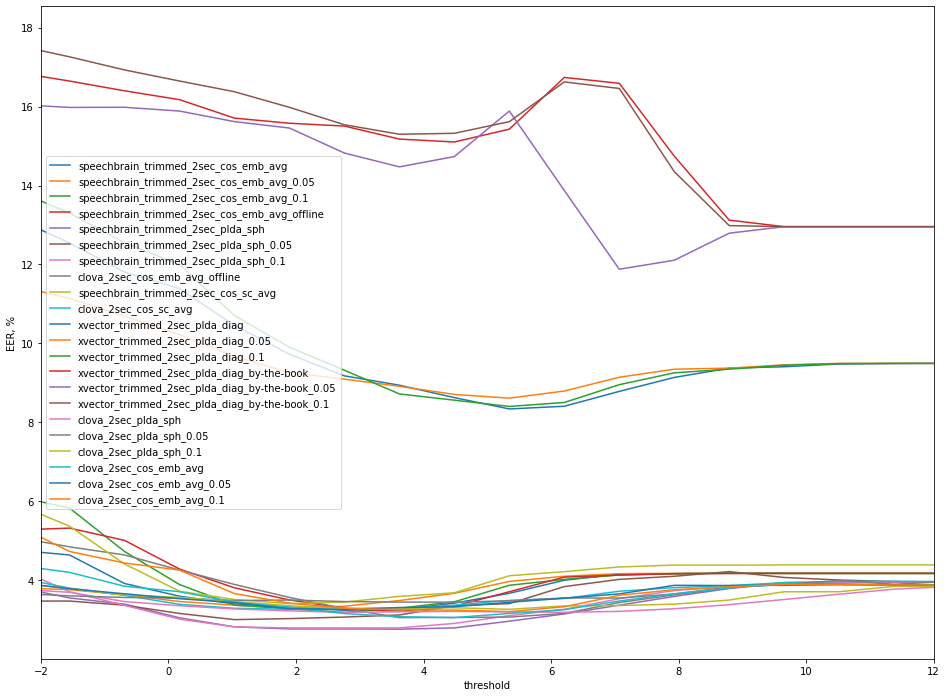

In [9]:
plt.figure(figsize=(16, 12))
plt.xlabel("threshold")
plt.ylabel("EER, %")
plt.xlim(-2, 12)


for run_name in results_dict:
    
    results_dict_run = results_dict[run_name]
    
    thresholds = results_dict_run['thresholds']
    alphas = results_dict_run['alphas']
    FAR_known = results_dict_run['FAR_known']
    FAR_unknown = results_dict_run['FAR_unknown']
    EER_known = results_dict_run['EER_know']
    EER_unknown = results_dict_run['EER_unknown']
    

    #TODO: unique combinations (itertools) of parameters for this run_id
    alpha_unique, idx = np.unique(alphas, return_inverse=True)
    for i, alpha in enumerate(alpha_unique):
        mask = idx == i
        
        if alpha > 0.1:
            continue
    
        if alpha >= 0:
            label = f"{run_name}_{alpha}"  
        else:
            label = run_name
        # visualize
        #plt.figure(figsize=(8,5))
        plt.plot(thresholds[mask], EER_known[mask], label=label);
        plt.legend()    
    
#plt.savefig("clova_EER_known.png")    

In [10]:
list(results_dict.keys())

['speechbrain_trimmed_2sec_cos_emb_avg',
 'speechbrain_trimmed_2sec_cos_emb_avg_offline',
 'speechbrain_trimmed_2sec_plda_sph',
 'clova_2sec_cos_emb_avg_offline',
 'speechbrain_trimmed_2sec_cos_sc_avg',
 'clova_2sec_cos_sc_avg',
 'xvector_trimmed_2sec_plda_diag',
 'xvector_trimmed_2sec_plda_diag_by-the-book',
 'clova_2sec_plda_sph',
 'clova_2sec_cos_emb_avg']

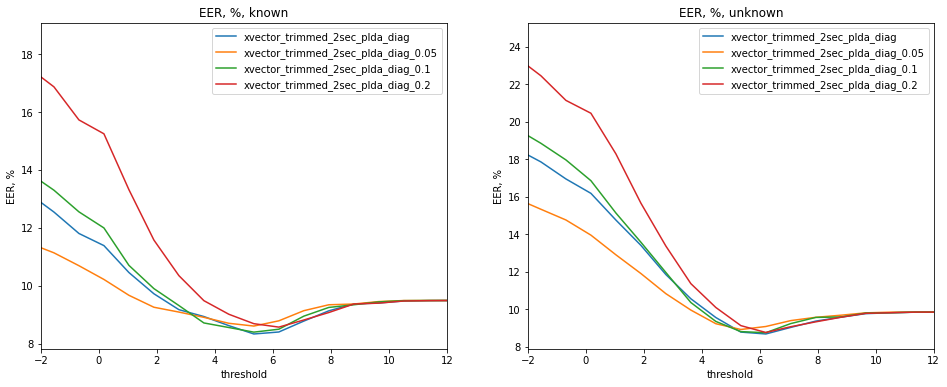

In [11]:
fig = plt.figure(figsize=(16, 6))
ax = fig.subplots(1, 2)
ax[0].set(xlabel="threshold", ylabel="EER, %")
ax[1].set(xlabel="threshold", ylabel="EER, %")
ax[0].set(xlim=(-2, 12))
ax[1].set(xlim=(-2, 12))
ax[0].set_title("EER, %, known")
ax[1].set_title("EER, %, unknown")


run_name = 'xvector_trimmed_2sec_plda_diag'

results_dict_run = results_dict[run_name]

thresholds = results_dict_run['thresholds']
alphas = results_dict_run['alphas']
FAR_known = results_dict_run['FAR_known']
FAR_unknown = results_dict_run['FAR_unknown']
EER_known = results_dict_run['EER_know']
EER_unknown = results_dict_run['EER_unknown']


alpha_unique, idx = np.unique(alphas, return_inverse=True)
for i, alpha in enumerate(alpha_unique):
    mask = idx == i
    #mask = (idx == i) * (thresholds > 0)
    if alpha > 0.2:
        continue

    if alpha >= 0:
        label = f"{run_name}_{alpha}"  
    else:
        label = run_name

    ax[0].plot(thresholds[mask], EER_known[mask], label=label);
    ax[0].legend()  
    
    ax[1].plot(thresholds[mask], EER_unknown[mask], label=label);
    ax[1].legend() 
    
plt.savefig("xvector", bbox_inches="tight")

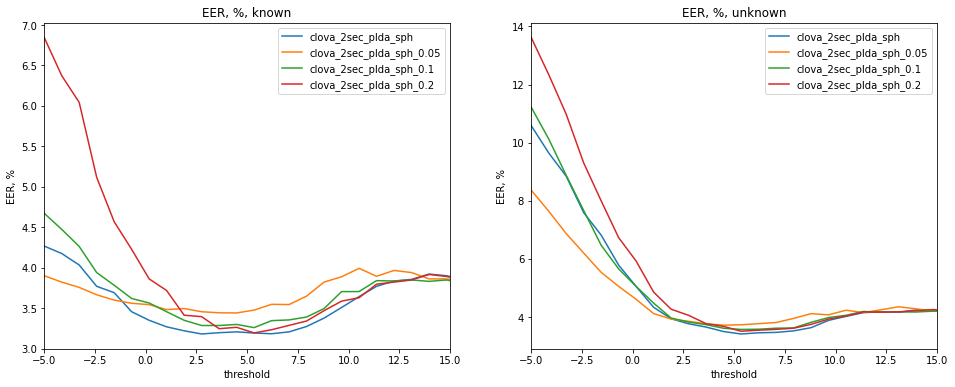

In [24]:
fig = plt.figure(figsize=(16, 6))
ax = fig.subplots(1, 2)
ax[0].set(xlabel="threshold", ylabel="EER, %")
ax[1].set(xlabel="threshold", ylabel="EER, %")
ax[0].set(xlim=(-5, 15))
ax[1].set(xlim=(-5, 15))
ax[0].set_title("EER, %, known")
ax[1].set_title("EER, %, unknown")



run_name = 'clova_2sec_plda_sph'

results_dict_run = results_dict[run_name]

thresholds = results_dict_run['thresholds']
alphas = results_dict_run['alphas']
FAR_known = results_dict_run['FAR_known']
FAR_unknown = results_dict_run['FAR_unknown']
EER_known = results_dict_run['EER_know']
EER_unknown = results_dict_run['EER_unknown']


alpha_unique, idx = np.unique(alphas, return_inverse=True)
for i, alpha in enumerate(alpha_unique):
    mask = idx == i
    #mask = (idx == i) * (thresholds > 0)
    if alpha > 0.2:
        continue

    if alpha >= 0:
        label = f"{run_name}_{alpha}"  
    else:
        label = run_name
    
    ax[0].plot(thresholds[mask], EER_known[mask], label=label);
    ax[0].legend()  
    
    ax[1].plot(thresholds[mask], EER_unknown[mask], label=label);
    ax[1].legend()   
    
plt.savefig("clova_2sec_plda_sph", bbox_inches="tight")

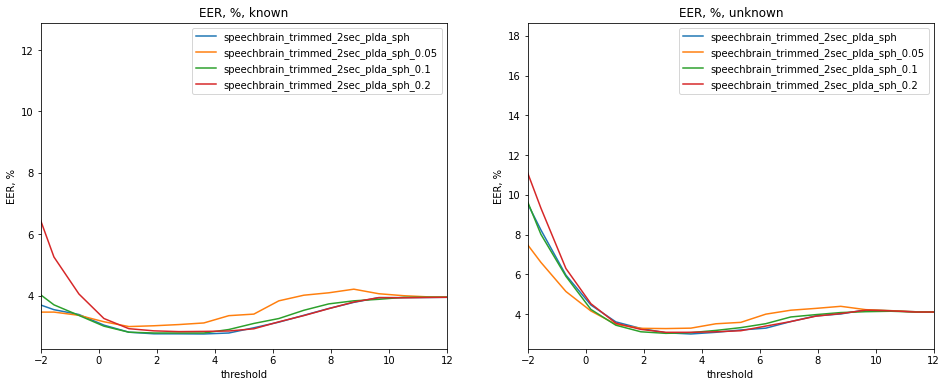

In [13]:
fig = plt.figure(figsize=(16, 6))
ax = fig.subplots(1, 2)
ax[0].set(xlabel="threshold", ylabel="EER, %")
ax[1].set(xlabel="threshold", ylabel="EER, %")
ax[0].set(xlim=(-2, 12))
ax[1].set(xlim=(-2, 12))
ax[0].set_title("EER, %, known")
ax[1].set_title("EER, %, unknown")



run_name = 'speechbrain_trimmed_2sec_plda_sph'

results_dict_run = results_dict[run_name]

thresholds = results_dict_run['thresholds']
alphas = results_dict_run['alphas']
FAR_known = results_dict_run['FAR_known']
FAR_unknown = results_dict_run['FAR_unknown']
EER_known = results_dict_run['EER_know']
EER_unknown = results_dict_run['EER_unknown']


alpha_unique, idx = np.unique(alphas, return_inverse=True)
for i, alpha in enumerate(alpha_unique):
    mask = idx == i
    #mask = (idx == i) * (thresholds > 0)
    if alpha > 0.2:
        continue

    if alpha >= 0:
        label = f"{run_name}_{alpha}"  
    else:
        label = run_name
    
    ax[0].plot(thresholds[mask], EER_known[mask], label=label);
    ax[0].legend()  
    
    ax[1].plot(thresholds[mask], EER_unknown[mask], label=label);
    ax[1].legend() 
    
plt.savefig("speechbrain_trimmed_2sec_plda_sph", bbox_inches="tight")

In [14]:
list(results_dict.keys())

['speechbrain_trimmed_2sec_cos_emb_avg',
 'speechbrain_trimmed_2sec_cos_emb_avg_offline',
 'speechbrain_trimmed_2sec_plda_sph',
 'clova_2sec_cos_emb_avg_offline',
 'speechbrain_trimmed_2sec_cos_sc_avg',
 'clova_2sec_cos_sc_avg',
 'xvector_trimmed_2sec_plda_diag',
 'xvector_trimmed_2sec_plda_diag_by-the-book',
 'clova_2sec_plda_sph',
 'clova_2sec_cos_emb_avg']

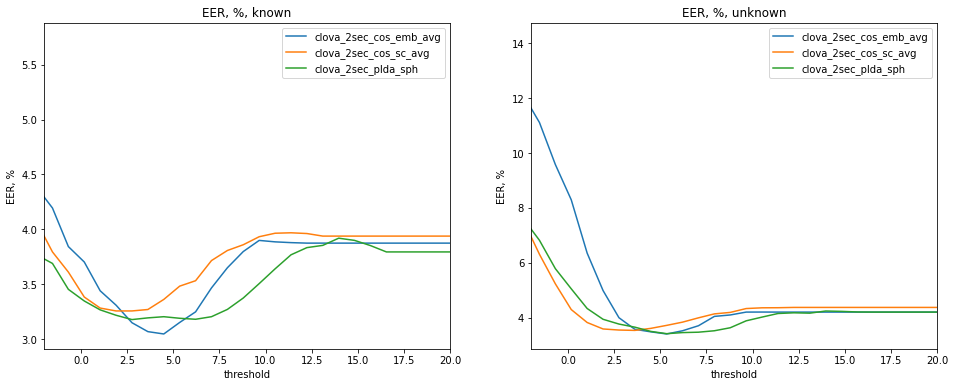

In [22]:
fig = plt.figure(figsize=(16, 6))
ax = fig.subplots(1, 2)
ax[0].set(xlabel="threshold", ylabel="EER, %")
ax[1].set(xlabel="threshold", ylabel="EER, %")
ax[0].set(xlim=(-2, 20))
ax[1].set(xlim=(-2, 20))
ax[0].set_title("EER, %, known")
ax[1].set_title("EER, %, unknown")



alpha = -1

for run_name in ['clova_2sec_cos_emb_avg', 'clova_2sec_cos_sc_avg', 'clova_2sec_plda_sph']:

    results_dict_run = results_dict[run_name]

    thresholds = results_dict_run['thresholds']
    alphas = results_dict_run['alphas']
    FAR_known = results_dict_run['FAR_known']
    FAR_unknown = results_dict_run['FAR_unknown']
    EER_known = results_dict_run['EER_know']
    EER_unknown = results_dict_run['EER_unknown']

    mask = alphas==alpha
    #mask = (alphas==alpha) * (thresholds > 0)

    if alpha >= 0:
        label = f"{run_name}_{alpha}"  
    else:
        label = run_name
        
    ax[0].plot(thresholds[mask], EER_known[mask], label=label);
    ax[0].legend()  
    
    ax[1].plot(thresholds[mask], EER_unknown[mask], label=label);
    ax[1].legend()   
    
plt.savefig("clova_2sec", bbox_inches="tight")

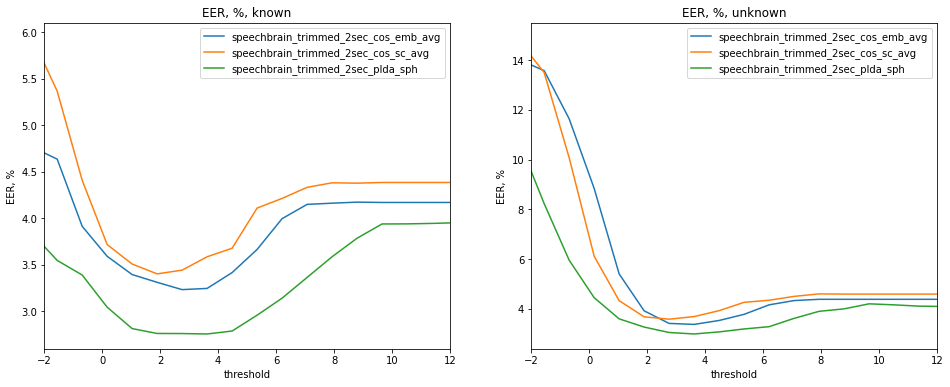

In [16]:
fig = plt.figure(figsize=(16, 6))
ax = fig.subplots(1, 2)
ax[0].set(xlabel="threshold", ylabel="EER, %")
ax[1].set(xlabel="threshold", ylabel="EER, %")
ax[0].set(xlim=(-2, 12))
ax[1].set(xlim=(-2, 12))
ax[0].set_title("EER, %, known")
ax[1].set_title("EER, %, unknown")



alpha = -1

for run_name in ['speechbrain_trimmed_2sec_cos_emb_avg', 'speechbrain_trimmed_2sec_cos_sc_avg', 'speechbrain_trimmed_2sec_plda_sph']:

    results_dict_run = results_dict[run_name]

    thresholds = results_dict_run['thresholds']
    alphas = results_dict_run['alphas']
    FAR_known = results_dict_run['FAR_known']
    FAR_unknown = results_dict_run['FAR_unknown']
    EER_known = results_dict_run['EER_know']
    EER_unknown = results_dict_run['EER_unknown']

    mask = alphas==alpha
    #mask = (alphas==alpha) * (thresholds > 0)

    if alpha >= 0:
        label = f"{run_name}_{alpha}"  
    else:
        label = run_name
        
    ax[0].plot(thresholds[mask], EER_known[mask], label=label);
    ax[0].legend()  
    
    ax[1].plot(thresholds[mask], EER_unknown[mask], label=label);
    ax[1].legend() 
    
plt.savefig("speechbrain_trimmed_2sec", bbox_inches="tight")

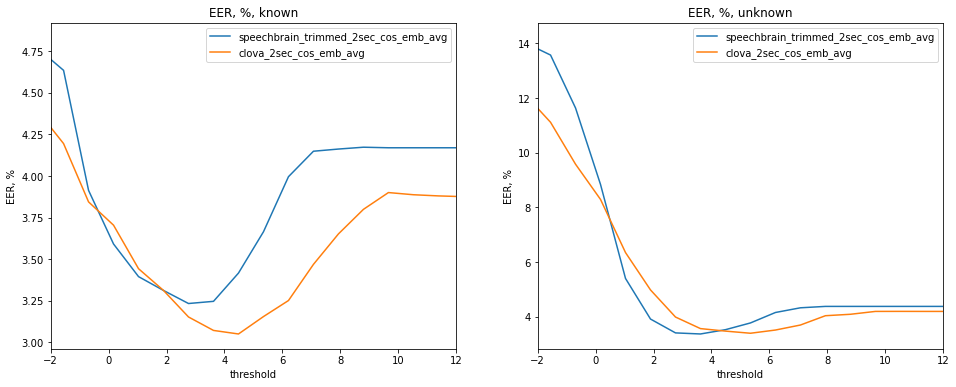

In [17]:
fig = plt.figure(figsize=(16, 6))
ax = fig.subplots(1, 2)
ax[0].set(xlabel="threshold", ylabel="EER, %")
ax[1].set(xlabel="threshold", ylabel="EER, %")
ax[0].set(xlim=(-2, 12))
ax[1].set(xlim=(-2, 12))
ax[0].set_title("EER, %, known")
ax[1].set_title("EER, %, unknown")



alpha = -1

for run_name in ['speechbrain_trimmed_2sec_cos_emb_avg', 'clova_2sec_cos_emb_avg']:

    results_dict_run = results_dict[run_name]

    thresholds = results_dict_run['thresholds']
    alphas = results_dict_run['alphas']
    FAR_known = results_dict_run['FAR_known']
    FAR_unknown = results_dict_run['FAR_unknown']
    EER_known = results_dict_run['EER_know']
    EER_unknown = results_dict_run['EER_unknown']

    mask = alphas==alpha
    #mask = (alphas==alpha) * (thresholds > 0)

    if alpha >= 0:
        label = f"{run_name}_{alpha}"  
    else:
        label = run_name
        
    ax[0].plot(thresholds[mask], EER_known[mask], label=label);
    ax[0].legend()  
    
    ax[1].plot(thresholds[mask], EER_unknown[mask], label=label);
    ax[1].legend() 
    
plt.savefig("cos_emb_avg", bbox_inches="tight")

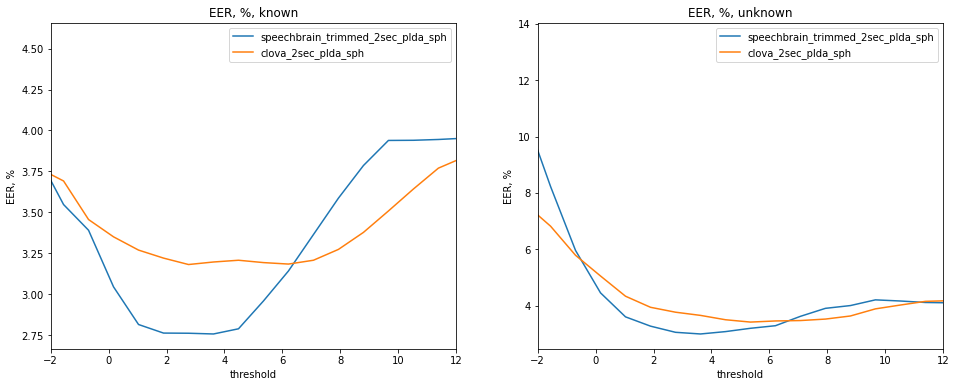

In [18]:
fig = plt.figure(figsize=(16, 6))
ax = fig.subplots(1, 2)
ax[0].set(xlabel="threshold", ylabel="EER, %")
ax[1].set(xlabel="threshold", ylabel="EER, %")
ax[0].set(xlim=(-2, 12))
ax[1].set(xlim=(-2, 12))
ax[0].set_title("EER, %, known")
ax[1].set_title("EER, %, unknown")



alpha = -1

for run_name in ['speechbrain_trimmed_2sec_plda_sph', 'clova_2sec_plda_sph']:

    results_dict_run = results_dict[run_name]

    thresholds = results_dict_run['thresholds']
    alphas = results_dict_run['alphas']
    FAR_known = results_dict_run['FAR_known']
    FAR_unknown = results_dict_run['FAR_unknown']
    EER_known = results_dict_run['EER_know']
    EER_unknown = results_dict_run['EER_unknown']

    mask = alphas==alpha
    #mask = (alphas==alpha) * (thresholds > 0)

    if alpha >= 0:
        label = f"{run_name}_{alpha}"  
    else:
        label = run_name
        
    ax[0].plot(thresholds[mask], EER_known[mask], label=label);
    ax[0].legend()  
    
    ax[1].plot(thresholds[mask], EER_unknown[mask], label=label);
    ax[1].legend() 
    
plt.savefig("plda_sph", bbox_inches="tight")

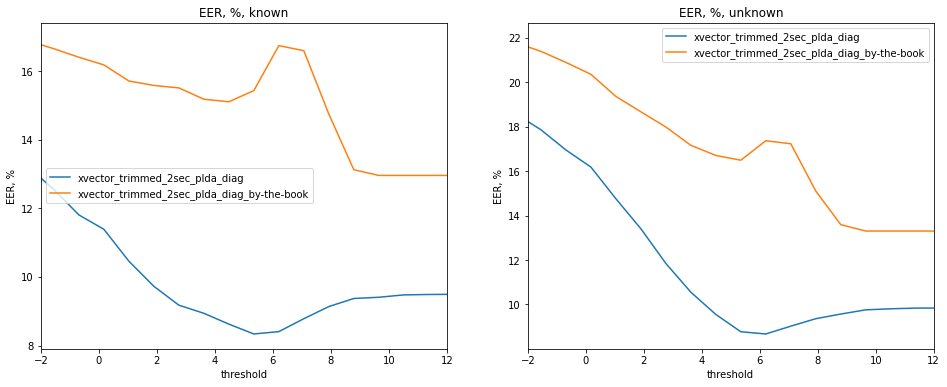

In [19]:
fig = plt.figure(figsize=(16, 6))
ax = fig.subplots(1, 2)
ax[0].set(xlabel="threshold", ylabel="EER, %")
ax[1].set(xlabel="threshold", ylabel="EER, %")
ax[0].set(xlim=(-2, 12))
ax[1].set(xlim=(-2, 12))
ax[0].set_title("EER, %, known")
ax[1].set_title("EER, %, unknown")



alpha = -1

for run_name in ['xvector_trimmed_2sec_plda_diag', 'xvector_trimmed_2sec_plda_diag_by-the-book']:

    results_dict_run = results_dict[run_name]

    thresholds = results_dict_run['thresholds']
    alphas = results_dict_run['alphas']
    FAR_known = results_dict_run['FAR_known']
    FAR_unknown = results_dict_run['FAR_unknown']
    EER_known = results_dict_run['EER_know']
    EER_unknown = results_dict_run['EER_unknown']
    

    mask = alphas==alpha
    #mask = (alphas==alpha) * (thresholds > 0)

    if alpha >= 0:
        label = f"{run_name}_{alpha}"  
    else:
        label = run_name
        
    ax[0].plot(thresholds[mask], EER_known[mask], label=label);
    ax[0].legend()  
    
    ax[1].plot(thresholds[mask], EER_unknown[mask], label=label);
    ax[1].legend() 
    
plt.savefig("xvector_by-the-book", bbox_inches="tight")

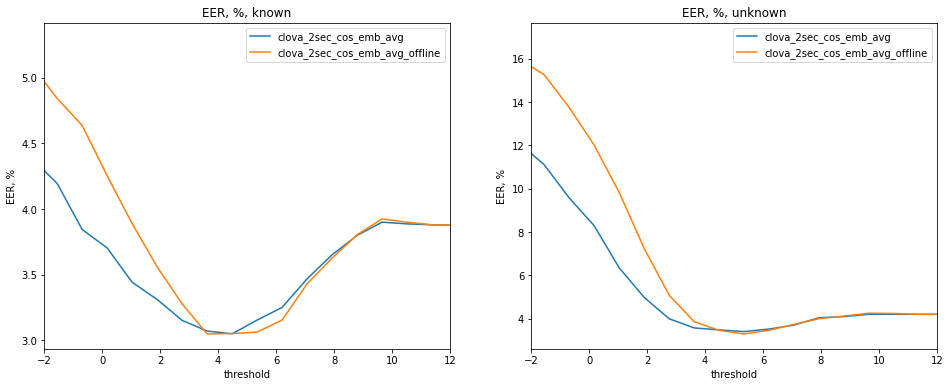

In [20]:
fig = plt.figure(figsize=(16, 6))
ax = fig.subplots(1, 2)
ax[0].set(xlabel="threshold", ylabel="EER, %")
ax[1].set(xlabel="threshold", ylabel="EER, %")
ax[0].set(xlim=(-2, 12))
ax[1].set(xlim=(-2, 12))
ax[0].set_title("EER, %, known")
ax[1].set_title("EER, %, unknown")



alpha = -1

for run_name in ['clova_2sec_cos_emb_avg', 'clova_2sec_cos_emb_avg_offline']:

    results_dict_run = results_dict[run_name]

    thresholds = results_dict_run['thresholds']
    alphas = results_dict_run['alphas']
    FAR_known = results_dict_run['FAR_known']
    FAR_unknown = results_dict_run['FAR_unknown']
    EER_known = results_dict_run['EER_know']
    EER_unknown = results_dict_run['EER_unknown']

    mask = alphas==alpha
    #mask = (alphas==alpha) * (thresholds > 0)

    if alpha >= 0:
        label = f"{run_name}_{alpha}"  
    else:
        label = run_name
        
    ax[0].plot(thresholds[mask], EER_known[mask], label=label);
    ax[0].legend()  
    
    ax[1].plot(thresholds[mask], EER_unknown[mask], label=label);
    ax[1].legend() 
    
plt.savefig("cos_emb_avg_offline", bbox_inches="tight")

In [4]:
def entropy(p):
    p = torch.tensor(p)
    eps = 1e-16
    H = -torch.sum(p * torch.log(p+eps))
    return H

In [5]:
entropy([0.1, 0.9])

tensor(0.3251)

tensor([0.3333, 0.3333, 0.3333])

In [27]:
a = 0.1

n = 1000
#(1 - (1-a)**n)/a

a = torch.tensor([a])

#probs = torch.tensor([1.])
probs = torch.ones(3)/3

#Ha = entropy(torch.cat([probs * a, 1-a]))
Ha = entropy(torch.cat([a, 1-a]))

for n in range(20):
    probs = torch.cat([probs * (1-a), a])
    print(entropy(probs), Ha*(1 - (1-a)**(n+4))/a, torch.exp(entropy(probs)))

tensor(1.3138) tensor([1.1180]) tensor(3.7204)
tensor(1.5075) tensor([1.3312]) tensor(4.5156)
tensor(1.6819) tensor([1.5232]) tensor(5.3756)
tensor(1.8388) tensor([1.6960]) tensor(6.2887)
tensor(1.9800) tensor([1.8515]) tensor(7.2425)
tensor(2.1071) tensor([1.9914]) tensor(8.2240)
tensor(2.2214) tensor([2.1173]) tensor(9.2205)
tensor(2.3244) tensor([2.2307]) tensor(10.2202)
tensor(2.4170) tensor([2.3327]) tensor(11.2124)
tensor(2.5004) tensor([2.4245]) tensor(12.1873)
tensor(2.5754) tensor([2.5071]) tensor(13.1371)
tensor(2.6430) tensor([2.5815]) tensor(14.0550)
tensor(2.7038) tensor([2.6484]) tensor(14.9359)
tensor(2.7585) tensor([2.7087]) tensor(15.7757)
tensor(2.8077) tensor([2.7629]) tensor(16.5719)
tensor(2.8520) tensor([2.8117]) tensor(17.3227)
tensor(2.8919) tensor([2.8556]) tensor(18.0275)
tensor(2.9278) tensor([2.8951]) tensor(18.6863)
tensor(2.9601) tensor([2.9307]) tensor(19.2998)
tensor(2.9892) tensor([2.9627]) tensor(19.8692)


/home/alexey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
